# Replicating _Russia's Billionaires_ (Daniel Treisman 2016, American Economic Review)

UCLA Political Science Professor Daniel Treisman published an interesting paper, [Russia’s
Billionaires](http://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.p20161068), in the American Economic Review in 2016 that used certain macroeconomic to create predictive model indicating for how many oligarchs should exist (I note with amusement the exclusivity with which the term _oligarchs_ is used solely to refer to Russian billionaires, whilst overlooking completely that quite a number of the billionaires in the alleged "free world" equally display the same characteristics as some of the Russian _oligarchs_ - Jeff Bezos' fusion of business with the security state in DC, Dassault family of billionaires via their namesake arms manufacturing empire - but for the purpose of this I ignore this word preference).

Prof Treisman uses MLE method to obtain the parameters of the model. Since the dependent variable can only take positive and discrete values (_division of human body has been found to be causal factor in numerous cases for cessation of key biological processes essential for survival_), the data is assumed to be following a Poisson distribution, over which MLE is applied to obtain the parameters.

- $Y_i$ is the number of oligarchs in _i_ country
- $x_{i1}$ is logGDP per capita
- $x_{i2}$ is logPopulation
- $x_{i3}$ is years in GATT and WTO

These are then used to estimate the following conditional version of the probability mass function for a Poisson distribution.

$$
f(y_i \mid \mathbf{x}_i) = \frac{\mu_i^{y_i}}{y_i!} e^{-\mu_i};
$$

$$
\text{where}, y_i = 0, 1, 2, \ldots , \infty
\\ 
\text{and}\ \mu_i = \exp(\mathbf{x}_i' \boldsymbol{\beta})
     = \exp(\beta_0 + \beta_1 x_{i1} + \ldots + \beta_k x_{ik})
$$

In [44]:
from numpy import exp
from scipy.special import factorial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from statsmodels.iolib.summary2 import summary_col

%matplotlib inline

In [11]:
df = pd.read_stata('https://github.com/QuantEcon/QuantEcon.lectures.code/raw/master/mle/fp.dta')
df.head()

,country,ccode,year,cyear,numbil,numbil0,numbilall,netw,netw0,netwall,...,gattwto08,mcapbdol,mcapbdol08,lnmcap08,topintaxnew,topint08,rintr,noyrs,roflaw,nrrents
0,United States,2.0,1990.0,21990.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,3060.000000,11737.599609,9.370638,39.799999,39.799999,4.988405,20.0,1.61,NaN
1,United States,2.0,1991.0,21991.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,4090.000000,11737.599609,9.370638,39.799999,39.799999,4.988405,20.0,1.61,NaN
2,United States,2.0,1992.0,21992.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,4490.000000,11737.599609,9.370638,39.799999,39.799999,4.988405,20.0,1.61,NaN
3,United States,2.0,1993.0,21993.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,5136.198730,11737.599609,9.370638,39.799999,39.799999,4.988405,20.0,1.61,NaN
4,United States,2.0,1994.0,21994.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,5067.016113,11737.599609,9.370638,39.799999,39.799999,4.988405,20.0,1.61,NaN


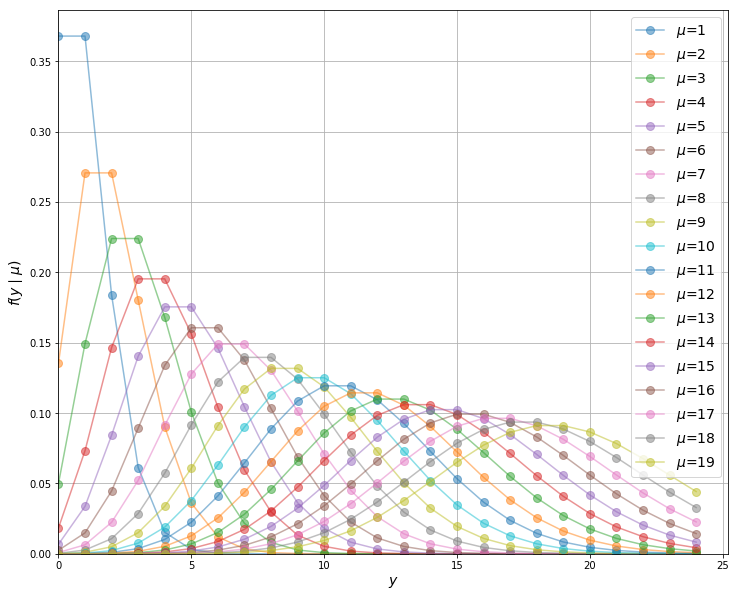

In [10]:
poisson_pmf = lambda y, μ: μ**y / factorial(y) * exp(-μ)
y_values = range(0, 25)

fig, ax = plt.subplots(figsize=(12, 10))

for μ in range(1,20):
    distribution = []
    for y_i in y_values:
        distribution.append(poisson_pmf(y_i, μ))
    ax.plot(y_values,
            distribution,
            label=f'$\mu$={μ}',
            alpha=0.5,
            marker='o',
            markersize=8)

ax.grid()
ax.set_xlabel('$y$', fontsize=14)
ax.set_ylabel('$f(y \mid \mu)$', fontsize=14)
ax.axis(xmin=0, ymin=0)
ax.legend(fontsize=14)

plt.show()

In [19]:
country_list = df['country'].drop_duplicates().tolist()

In [34]:
ind_bil["year"] = pd.to_numeric(ind_bil["year"])
ind_bil["numbil0"]= pd.to_numeric(ind_bil["numbil0"])

In [28]:
ind_bil = df[df["country"] == "India"].loc[:,['year','numbil0']]
rus_bil = df[df["country"] == "Russian Federation"].loc[:,['year','numbil0']]

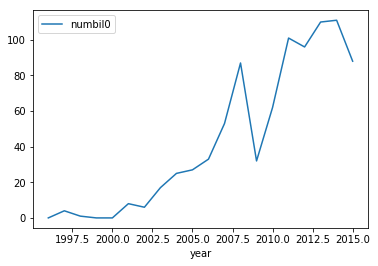

In [41]:
rus_bil.dropna().plot(x = "year", y = "numbil0")

C:\Users\sidpa\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')


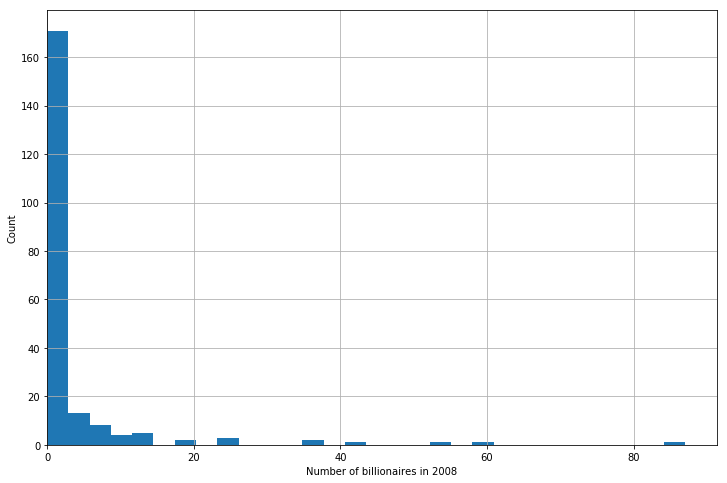

In [42]:
numbil0_2008 = df[(df['year'] == 2008) & (df['country'] != 'United States')].loc[:, 'numbil0']

plt.subplots(figsize=(12, 8))
plt.hist(numbil0_2008, bins=30)
plt.xlim(xmin=0)
plt.grid()
plt.xlabel('Number of billionaires in 2008')
plt.ylabel('Count')
plt.show()

In [80]:
# Add a constant
df['const'] = 1

# Variable sets
reg1 = ['const', 'lngdppc', 'lnpop', 'gattwto08']
reg2 = ['const', 'lngdppc', 'lnpop',
        'gattwto08', 'lnmcap08', 'rintr', 'topint08']
reg3 = ['const', 'lngdppc', 'lnpop', 'gattwto08', 'lnmcap08',
        'rintr', 'topint08', 'nrrents', 'roflaw']

In [140]:
df_iter = df[df["year"] == 2005].copy()

sm.Poisson(df_iter[['numbil0']], df_iter[reg3],missing='drop').fit(cov_type='HC0', maxiter=100)

Optimization terminated successfully.
         Current function value: 1.313392
         Iterations 10


In [261]:
mle_range = [i for i in range(2005,2014)]
results = []
df_dump = []
for year in mle_range:
    
    df_iter = df[df["year"] == year].copy()
    df_dump.append(df_iter)
    poisson_reg = sm.GLM(df_iter[['numbil0']], df_iter[reg3],missing='drop', family=sm.families.Poisson()).fit(cov_type='HC0', maxiter=100)
    results.append(poisson_reg)

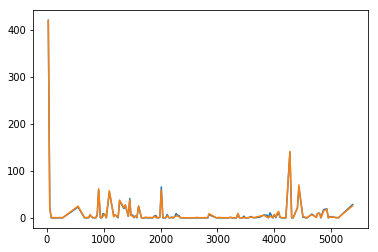

In [262]:
plt.plot(poisson_reg.fittedvalues + poisson_reg.resid_pearson, label = "Actual")
plt.plot(poisson_reg.fittedvalues, label = "Fit")

C:\Users\sidpa\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


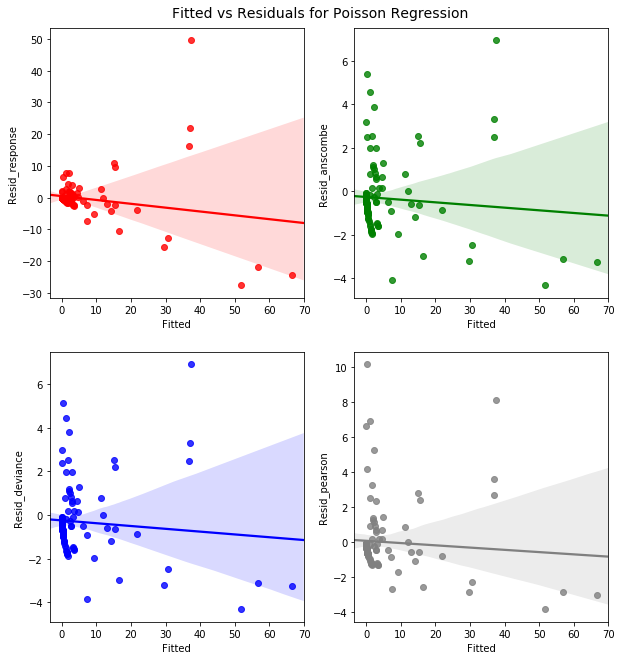

In [286]:
comb = pd.concat([results[3].resid_response, results[3].resid_anscombe, results[3].resid_deviance, results[3].resid_pearson, results[3].fittedvalues[1:]], axis = 1)
comb.columns = ["Resid_response", "Resid_anscombe", "Resid_deviance", "Resid_pearson", "Fitted"]

plt.figure(figsize = [10,10])
plt.suptitle("Fitted vs Residuals for Poisson Regression", fontsize = 14)

plt.subplot(221)
sns.regplot(x = "Fitted", y = "Resid_response", data = comb, color = "red")
plt.subplot(222)
sns.regplot(x = "Fitted", y = "Resid_anscombe", data = comb, color = "green")
plt.subplot(223)
sns.regplot(x = "Fitted", y = "Resid_deviance", data = comb, color = "blue")
plt.subplot(224)
sns.regplot(x = "Fitted", y = "Resid_pearson", data = comb, color = "grey")
plt.subplots_adjust(top=0.95)

In [334]:
df_2008 = df[df["year"] == 2008].copy()
regs = [reg1, reg2, reg3]
reg_names = ['Model 1', 'Model 2', 'Model 3']
info_dict = {'Pseudo R-squared': lambda x: f"{x.prsquared:.2f}",
             'No. observations': lambda x: f"{int(x.nobs):d}"}
regressor_order = ['const',
                   'lngdppc',
                   'lnpop',
                   'gattwto08',
                   'lnmcap08',
                   'rintr',
                   'topint08',
                   'nrrents',
                   'roflaw']
results = []

for reg in regs:
    result = sm.Poisson(df_2008['numbil0'], df_2008[reg], missing='drop').fit(cov_type='HC0')
    results.append(result)

results_table = summary_col(results=results,
                            float_format='%0.3f',
                            stars=True,
                            model_names=reg_names,
                            info_dict=info_dict,
                            regressor_order=regressor_order)
results_table.add_title('Table 1 - Explaining the Number of Billionaires in 2008')
print(results_table)

Optimization terminated successfully.
         Current function value: 2.226090
         Iterations 9
Optimization terminated successfully.
         Current function value: 1.982676
         Iterations 9
Optimization terminated successfully.
         Current function value: 1.954384
         Iterations 9
Table 1 - Explaining the Number of Billionaires in 2008
                  Model 1    Model 2    Model 3  
-------------------------------------------------
const            -29.050*** -19.444*** -20.858***
                 (2.578)    (4.820)    (4.255)   
lngdppc          1.084***   0.717***   0.737***  
                 (0.138)    (0.244)    (0.233)   
lnpop            1.171***   0.806***   0.929***  
                 (0.097)    (0.213)    (0.195)   
gattwto08        0.006      0.007      0.004     
                 (0.007)    (0.006)    (0.006)   
lnmcap08                    0.399**    0.286*    
                            (0.172)    (0.167)   
rintr                       -0.010    

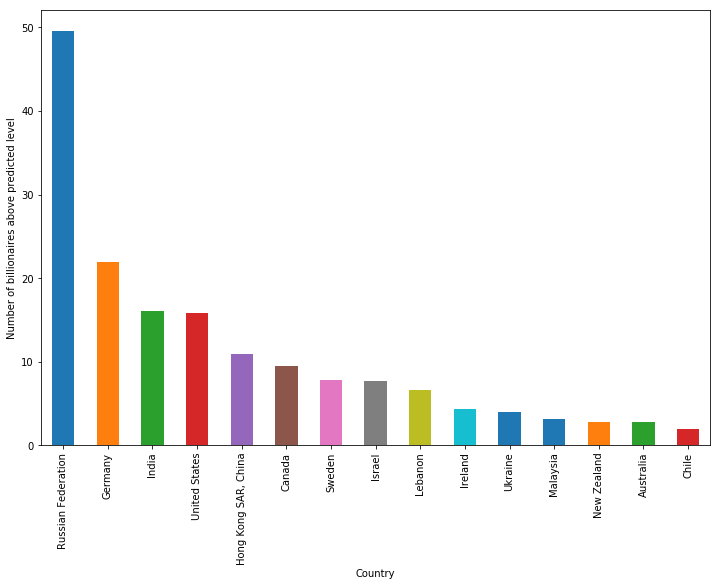

In [343]:
data = ['const', 'lngdppc', 'lnpop', 'gattwto08', 'lnmcap08', 'rintr',
        'topint08', 'nrrents', 'roflaw', 'numbil0', 'country']
results_df = df_2008[data].dropna()

# Use last model (model 3)
results_df['prediction'] = results[-1].predict()

# Calculate difference
results_df['difference'] = results_df['numbil0'] - results_df['prediction']

# Sort in descending order
results_df.sort_values('difference', ascending=False, inplace=True)

# Plot the first 15 data points
results_df[:15].plot('country', 'difference', kind='bar', figsize=(12,8), legend=False)
plt.ylabel('Number of billionaires above predicted level')
plt.xlabel('Country')
plt.show()